**Outline**
* [Get the clustering result](#getcluster)
* [Heatmap](#heatmap)


* [Replace with the new cluster](#replace)
* [Team level](#team)
    * [Performance + weapon + class](#team_all)
    * [Weapon + class](#team_Wc)    
    * [Team Distance](#team_dist)      
    * [Find NN for teams](#findnn) 
    * [Find the team with the highest win-loss](#winloss) 
    * [Find the team with the highest learning rate](#learning)
* [Players to Players](#players)
    * [Players weapon + class](#player_wc) 
    * [Players distance](#player_dist) 
    * [Players to players mapping](#player_map) 
* [Final Recommendation](#rec)


In [125]:
import numpy as np
#from py_pcha.PCHA import PCHA
import pandas as pd
import pandas as pd
import numpy as np
from sklearn.preprocessing import scale
from sklearn.preprocessing import minmax_scale
from sklearn.preprocessing import MinMaxScaler
from sklearn import preprocessing
from sklearn.preprocessing import scale
from sklearn import mixture
from sklearn.cluster import KMeans
import os
from scipy.spatial.distance import squareform, pdist,cdist
import textwrap
import json
import itertools

import plotly
import plotly.graph_objs as go
plotly.offline.init_notebook_mode()
from plotly import __version__
from plotly.offline import download_plotlyjs, init_notebook_mode, plot, iplot
np.random.seed(12345)

In [126]:
### Read data
#os.chdir('/Users/yuecui/Desktop/Destiny/final_team')
final_cluster_clean_id=pd.read_csv("final_cluster_clean_5_10.csv")
final_cluster_clean=final_cluster_clean_id.drop(["playersID","teamID"],axis=1)
newtable = pd.read_csv("final_label_5_15.csv")
newset = newtable[["playersID","teamID","performance_cluster","weapon_pro_cluster","Character_Class"]]

In [127]:
newtable.head()

Ability  Character_Level   Grenade       KDA  Lightlevel     Melee  \
0      0.0              0.8  0.400000  0.160906    0.893532  0.022676   
1      0.0              0.8  0.135000  0.072336    0.869851  0.142857   
2      0.0              1.0  0.112500  0.649424    0.938433  0.102041   
3      0.0              0.8  0.337500  0.474097    0.904478  0.102041   
4      0.0              1.0  0.289286  0.261678    0.997015  0.043732   

      Super   assists  avg_score_per_life    deaths       ...         \
0  0.142222  0.401648            0.035382  0.562203       ...          
1  0.056000  0.277034            0.032289  0.711111       ...          
2  0.090000  0.592173            0.177250  0.247863       ...          
3  0.060000  0.163491            0.134940  0.230769       ...          
4  0.000000  0.592173            0.055214  0.449328       ...          

   Pro Sidearm  Pro Sniper Rifle  Pro Submachine Gun  Pro Sword  \
0     0.000000          0.000000            0.000000        0.0   
1     0.000000          0.000000            0.000000        0.0   
2     0.000000          0.000000            0.490788        0.0   
3     0.249384          0.313428            0.280407        0.0   
4     0.000000          0.000000            0.403929        0.0   

   Pro Trace Rifle  performance_cluster  weapon_pro_cluster  \
0              0.0                    4                   6   
1              0.0                    3                   6   
2              0.0                    4                   1   
3              0.0                    4                   3   
4              0.0                    0                   1   

             playersID                                             teamID  \
0  2305843009260294880  2305843009260294880230584300926065511223058430...   
1  2305843009260301047  2305843009260301047230584300926407495723058430...   
2  2305843009260304802  2305843009260304802230584300926112491023058430...   
3  2305843009260306096  2305843009260306096230584300926893816923058430...   
4  2305843009260307017  2305843009260307017230584300926409646823058430...   

   Character_Class  
0          Warlock  
1          Warlock  
2           Hunter  
3          Warlock  
4           Hunter  

[5 rows x 47 columns]

In [128]:
newtable["Character_Class"].value_counts()

Hunter     1570
Titan      1127
Warlock    1019
Name: Character_Class, dtype: int64

In [129]:
winloss = pd.read_csv("WinRatio_upto15.csv").drop("Unnamed: 0",axis=1)
winloss.head()

teamID  Wins
0  2305843009260293961230584300926060138823058430...   0.0
1  2305843009260293961230584300926228396323058430...   1.0
2  2305843009260293963230584300926039475323058430...   1.0
3  2305843009260293963230584300926043395823058430...   1.0
4  2305843009260293963230584300926043395823058430...   1.0

In [130]:
learning = pd.read_csv("team_learning_rates.csv")
learning.head()

teamID  lr_Grenade  lr_Melee  \
0  2305843009260293961230584300926060138823058430...         0.0       0.0   
1  2305843009260293961230584300926228396323058430...         0.0       0.0   
2  2305843009260293963230584300926039475323058430...         0.0       0.0   
3  2305843009260293963230584300926043395823058430...         0.0       0.0   
4  2305843009260293963230584300926043395823058430...         0.0       0.0   

   lr_Super  lr_assists  lr_avg_score_per_life  lr_KDA  lr_efficiency  
0       0.0         0.0                    0.0     0.0            0.0  
1       0.0         0.0                    0.0     0.0            0.0  
2       0.0         0.0                    0.0     0.0            0.0  
3       0.0         0.0                    0.0     0.0            0.0  
4       0.0         0.0                    0.0     0.0            0.0

In [131]:
playstyle = pd.read_csv("per_recomendation_data_6_8.csv")

In [132]:
import json
with open('weapon_info.json', 'r') as fp:
    weapon_list = json.load(fp)
with open('player_weapon_sort_frequency.json', 'r') as fp:
    referenceid_list = json.load(fp)

def weapon_from_team(team):
    team_id=str(team)
    team_id_list=[team_id[0:19],team_id[19:38],team_id[38:57],team_id[57:76]]
    final_dic={}
    for teamid in team_id_list:
        weapon_l=[]
        for re in referenceid_list[teamid]:
            weapon_l.append(weapon_list[str(re)])
        final_dic[teamid]=weapon_l[:3] #top three weapons    
    return final_dic

In [133]:
def my_scaler(x):
    """standardize the predictors"""
    
    new_x = pd.DataFrame(scale(x, axis=0, with_mean=True, with_std=True, copy=True))
    new_x.columns = x.columns
    
    return new_x

def my_normal(x):
    """normalize the predictors"""
    
    scaler = MinMaxScaler(feature_range=(0, 1)) 
    scaled_values = scaler.fit_transform(x)
    new_x = pd.DataFrame(scaled_values)
    new_x.columns = x.columns

    return new_x

In [134]:
def cluster(dt,cluster_content,scale, cluster_number, cluster_method):
    player_feature_df=dt
    performance_cluster=[]
    weapon_cluster=[]
    
    if scale=="MinMax":
        min_max_scaler = preprocessing.MinMaxScaler()
        player_feature_df = my_normal(player_feature_df)
        
    if scale=="Standardization":
        player_feature_df = my_scaler(player_feature_df)
            
    if cluster_content=="performance":
        cluster_dt=player_feature_df[['Ability', 'Grenade', 'Melee','Super', 'assists']]
        
    if cluster_content=="weapon":
        cluster_dt=player_feature_df[['Pro Auto Rifle',
                                      'Pro Fusion Rifle', 'Pro Grenade Launcher', 'Pro Hand Cannon',
                                      'Pro Linear Fusion Rifle', 'Pro Pulse Rifle', 'Pro Rocket Launcher',
                                      'Pro Scout Rifle', 'Pro Shotgun', 'Pro Sidearm', 'Pro Sniper Rifle',
                                      'Pro Submachine Gun', 'Pro Sword', 'Pro Trace Rifle']]   
        
    if cluster_method=="GMM":
        clf = mixture.GaussianMixture(n_components=cluster_number, covariance_type='full',max_iter=1000)
        clf.fit(cluster_dt)
        cluster_dt = cluster_dt.copy()
        if cluster_content=="performance":
            performance_cluster = clf.predict(cluster_dt)
        if cluster_content=="weapon":
            weapon_cluster = clf.predict(cluster_dt) 
            
    if cluster_method=="KMeans":
        model = KMeans(n_clusters=cluster_number, n_init=30)
        model.fit(cluster_dt)
        cluster_dt = cluster_dt.copy()
        if cluster_content=="performance":
            performance_cluster = model.predict(cluster_dt)
        if cluster_content=="weapon":
            weapon_cluster = model.predict(cluster_dt)        
            
    if cluster_method=="AA":
        cluster_matrix = cluster_dt.as_matrix()
        XC, S, C, SSE, varexpl = PCHA(cluster_matrix, noc=cluster_number, delta=0.1)
        XC_df=pd.DataFrame(XC)
        if cluster_content=="performance":
            performance_cluster = XC_df.idxmax(axis=1)
        if cluster_content=="weapon":
            weapon_cluster = XC_df.idxmax(axis=1)       
            
    return performance_cluster,weapon_cluster,player_feature_df

### <a id='getcluster'>Get the clustering result</a>

In [151]:
np.random.seed(12345)

In [152]:
### GMM Use standarization
performance_cluster_std = cluster(dt=final_cluster_clean,cluster_content="performance",scale="Standardization", 
        cluster_number = 5, cluster_method="GMM")
dt_scaled = performance_cluster_std[2]
performance_cluster_std = performance_cluster_std[0]


In [153]:
weapon_cluster_std = cluster(dt=final_cluster_clean,cluster_content="weapon",scale="MinMax", 
        cluster_number = 7, cluster_method="GMM")
weapon_cluster_std = weapon_cluster_std[1]

### <a id='heatmap'>Creat a cluster heatmap</a>

In [154]:
dt_scaled["performance_cluster"]=performance_cluster_std
dt_scaled["weapon_pro_cluster"]=weapon_cluster_std
dt_scaled.head()

Ability  Character_Level   Grenade       KDA  Lightlevel     Melee  \
0 -0.188045        -0.530454  1.778078 -0.306576   -0.133540 -0.716701   
1 -0.188045        -0.530454 -0.168402 -1.007117   -0.392580  0.767962   
2 -0.188045         1.247988 -0.333669  3.557328    0.357603  0.263737   
3 -0.188045        -0.530454  1.319002  2.170584   -0.013815  0.263737   
4 -0.188045         1.247988  0.964858  0.490474    0.998401 -0.456585   

      Super   assists  avg_score_per_life    deaths         ...          \
0  1.800121  0.732401           -0.955507  1.016670         ...           
1  0.194462 -0.196141           -0.995370  1.854293         ...           
2  0.827621  2.152072            0.872793 -0.751528         ...           
3  0.268951 -1.042189            0.327521 -0.847684         ...           
4 -0.848389  2.152072           -0.699927  0.381736         ...           

   Pro Rocket Launcher  Pro Scout Rifle  Pro Shotgun  Pro Sidearm  \
0            -0.294575        -0.902982    -0.461777    -0.615560   
1             1.906804         0.079749    -0.461777    -0.615560   
2             1.164482        -1.259059    -0.461777    -0.615560   
3            -0.241563        -0.595426    -0.461777     1.328976   
4            -0.752745        -0.215758    -0.461777    -0.615560   

   Pro Sniper Rifle  Pro Submachine Gun  Pro Sword  Pro Trace Rifle  \
0         -0.285295           -0.731355  -0.290809        -0.171824   
1         -0.285295           -0.731355  -0.290809        -0.171824   
2         -0.285295            1.961218  -0.290809        -0.171824   
3          3.199766            0.807021  -0.290809        -0.171824   
4         -0.285295            1.484688  -0.290809        -0.171824   

   performance_cluster  weapon_pro_cluster  
0                    0                   6  
1                    0                   6  
2                    0                   6  
3                    0                   2  
4                    0                   6  

[5 rows x 44 columns]

In [155]:
dt_scaled.columns

Index(['Ability', 'Character_Level', 'Grenade', 'KDA', 'Lightlevel', 'Melee',
       'Super', 'assists', 'avg_score_per_life', 'deaths', 'efficiency',
       'kills', 'score', 'Auto Rifle', 'Fusion Rifle', 'Grenade Launcher',
       'Hand Cannon', 'Linear Fusion Rifle', 'Pulse Rifle', 'Rocket Launcher',
       'Scout Rifle', 'Shotgun', 'Sidearm', 'Sniper Rifle', 'Submachine Gun',
       'Sword', 'Trace Rifle', 'weapon_kills', 'Pro Auto Rifle',
       'Pro Fusion Rifle', 'Pro Grenade Launcher', 'Pro Hand Cannon',
       'Pro Linear Fusion Rifle', 'Pro Pulse Rifle', 'Pro Rocket Launcher',
       'Pro Scout Rifle', 'Pro Shotgun', 'Pro Sidearm', 'Pro Sniper Rifle',
       'Pro Submachine Gun', 'Pro Sword', 'Pro Trace Rifle',
       'performance_cluster', 'weapon_pro_cluster'],
      dtype='object')

In [156]:
#perfromance heatmap
per_d=dt_scaled[['Ability', 'Grenade', 'Melee',
       'Super', 'assists',"performance_cluster"]]


# split df into cluster groups
grouped = per_d.groupby(['performance_cluster'], sort=True)

# compute sums for every column in every group
means = grouped.mean()
means

data = [go.Heatmap( z=means.values.tolist(), 
                   y=['Persona A', 'Persona B', 'Persona C', 'Persona D', 'Persona E'],
                   x=['Ability', 'Grenade', 'Melee',
       'Super', 'assists'
                     ],
                   colorscale='Viridis')]
init_notebook_mode(connected=True)
iplot(data)

In [158]:
weapon_d=dt_scaled[['Pro Auto Rifle',
       'Pro Fusion Rifle', 'Pro Grenade Launcher', 'Pro Hand Cannon',
       'Pro Linear Fusion Rifle', 'Pro Pulse Rifle', 'Pro Rocket Launcher',
       'Pro Scout Rifle', 'Pro Shotgun', 'Pro Sidearm', 'Pro Sniper Rifle',
       'Pro Submachine Gun', 'Pro Sword', 'Pro Trace Rifle']]
weapon_d.columns=['Auto Rifle',
       'Fusion Rifle', 'Grenade Launcher', 'Hand Cannon',
       'Linear Fusion Rifle', 'Pulse Rifle', 'Rocket Launcher',
       'Scout Rifle', 'Shotgun', 'Sidearm', 'Sniper Rifle',
       'Submachine Gun', 'Sword', 'Trace Rifle']
weapon_d["weapon_pro_cluster"]=weapon_cluster_std

/Users/wangziwen/anaconda/envs/python2.7/lib/python3.6/site-packages/ipykernel_launcher.py:11: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



In [159]:
weapon_d.head()

Auto Rifle  Fusion Rifle  Grenade Launcher  Hand Cannon  \
0    1.391375     -0.392334         -0.338647    -0.361672   
1    0.359851     -0.392334         -0.338647    -0.361672   
2    0.419124     -0.392334         -0.338647    -0.361672   
3   -0.933574      0.390690         -0.338647     0.227106   
4    0.140914     -0.392334          2.181055    -0.361672   

   Linear Fusion Rifle  Pulse Rifle  Rocket Launcher  Scout Rifle   Shotgun  \
0            -0.075217     1.939564        -0.294575    -0.902982 -0.461777   
1            -0.075217     0.458309         1.906804     0.079749 -0.461777   
2            -0.075217    -0.415526         1.164482    -1.259059 -0.461777   
3            -0.075217    -0.415526        -0.241563    -0.595426 -0.461777   
4            -0.075217    -0.415526        -0.752745    -0.215758 -0.461777   

    Sidearm  Sniper Rifle  Submachine Gun     Sword  Trace Rifle  \
0 -0.615560     -0.285295       -0.731355 -0.290809    -0.171824   
1 -0.615560     -0.285295       -0.731355 -0.290809    -0.171824   
2 -0.615560     -0.285295        1.961218 -0.290809    -0.171824   
3  1.328976      3.199766        0.807021 -0.290809    -0.171824   
4 -0.615560     -0.285295        1.484688 -0.290809    -0.171824   

   weapon_pro_cluster  
0                   6  
1                   6  
2                   6  
3                   2  
4                   6

In [160]:
#weapon heatmap


# split df into cluster groups
grouped = weapon_d.groupby(['weapon_pro_cluster'], sort=True)

# compute sums for every column in every group
means = grouped.mean()
means

data = [go.Heatmap( z=means.values.tolist(), 
                   y=['Persona A', 'Persona B', 'Persona C', 'Persona D', 'Persona E', 'Persona F','Persona G'],
                   x=['Auto Rifle',
       'Fusion Rifle', 'Grenade Launcher', 'Hand Cannon',
       'Linear Fusion Rifle', 'Pulse Rifle', 'Rocket Launcher',
       'Scout Rifle', 'Shotgun', 'Sidearm', 'Sniper Rifle',
       'Submachine Gun', 'Sword', 'Trace Rifle'
                     ],
                   colorscale='Viridis')]
init_notebook_mode(connected=True)
iplot(data)

### Create kill plot on weapon 

In [161]:
final_cluster_clean.columns

Index(['Ability', 'Character_Level', 'Grenade', 'KDA', 'Lightlevel', 'Melee',
       'Super', 'assists', 'avg_score_per_life', 'deaths', 'efficiency',
       'kills', 'score', 'Auto Rifle', 'Fusion Rifle', 'Grenade Launcher',
       'Hand Cannon', 'Linear Fusion Rifle', 'Pulse Rifle', 'Rocket Launcher',
       'Scout Rifle', 'Shotgun', 'Sidearm', 'Sniper Rifle', 'Submachine Gun',
       'Sword', 'Trace Rifle', 'weapon_kills', 'Pro Auto Rifle',
       'Pro Fusion Rifle', 'Pro Grenade Launcher', 'Pro Hand Cannon',
       'Pro Linear Fusion Rifle', 'Pro Pulse Rifle', 'Pro Rocket Launcher',
       'Pro Scout Rifle', 'Pro Shotgun', 'Pro Sidearm', 'Pro Sniper Rifle',
       'Pro Submachine Gun', 'Pro Sword', 'Pro Trace Rifle'],
      dtype='object')

In [162]:
dt_weapon_kills=final_cluster_clean[['Auto Rifle', 'Fusion Rifle', 'Grenade Launcher',
       'Hand Cannon', 'Linear Fusion Rifle', 'Pulse Rifle', 'Rocket Launcher',
       'Scout Rifle', 'Shotgun', 'Sidearm', 'Sniper Rifle', 'Submachine Gun',
       'Sword', 'Trace Rifle', 'weapon_kills']]

In [163]:
dt_weapon_kills.head()

Auto Rifle  Fusion Rifle  Grenade Launcher  Hand Cannon  \
0   39.000000           0.0             0.000          0.0   
1    3.800000           0.0             0.000          0.0   
2    5.833333           0.0             0.000          0.0   
3    2.000000           1.0             0.000          1.0   
4    4.363636           0.0             2.125          0.0   

   Linear Fusion Rifle  Pulse Rifle  Rocket Launcher  Scout Rifle  Shotgun  \
0                  0.0         17.6             3.15     3.666667      0.0   
1                  0.0          1.0             2.80     2.111111      0.0   
2                  0.0          0.0             3.00     0.000000      0.0   
3                  0.0          0.0             1.00     1.944444      0.0   
4                  0.0          0.0             0.00     2.150000      0.0   

   Sidearm  Sniper Rifle  Submachine Gun  Sword  Trace Rifle  weapon_kills  
0      0.0           0.0        0.000000    0.0          0.0     63.416667  
1      0.0           0.0        0.000000    0.0          0.0      9.711111  
2      0.0           0.0        5.600000    0.0          0.0     14.433333  
3      4.5           2.6        4.000000    0.0          0.0     18.044444  
4      0.0           0.0        4.052632    0.0          0.0     12.691268

In [164]:
weapon_kills_stats=pd.DataFrame(dt_weapon_kills.sum()).reset_index()
weapon_kills_stats.columns=["weapon class","total kills"]

In [165]:
weapon_kills_stats=weapon_kills_stats[:14]
weapon_kills_stats

weapon class   total kills
0            Auto Rifle  13231.075086
1          Fusion Rifle   1559.572446
2      Grenade Launcher    903.749945
3           Hand Cannon   3326.634606
4   Linear Fusion Rifle     42.428571
5           Pulse Rifle   2659.238512
6       Rocket Launcher   3526.232244
7           Scout Rifle   9850.356571
8               Shotgun   1673.365244
9               Sidearm   4039.141621
10         Sniper Rifle    596.176160
11       Submachine Gun   4924.421997
12                Sword   1084.939467
13          Trace Rifle    829.012377

In [166]:
kill=sum(weapon_kills_stats["total kills"])
kill

48246.34484793312

In [167]:
weapon_kills_stats["%kills by weapon"]=weapon_kills_stats["total kills"]/kill

In [168]:
weapon_kills_stats=weapon_kills_stats.sort_values("%kills by weapon",ascending=False)
weapon_kills_stats

weapon class   total kills  %kills by weapon
0            Auto Rifle  13231.075086          0.274240
7           Scout Rifle   9850.356571          0.204168
11       Submachine Gun   4924.421997          0.102068
9               Sidearm   4039.141621          0.083719
6       Rocket Launcher   3526.232244          0.073088
3           Hand Cannon   3326.634606          0.068951
5           Pulse Rifle   2659.238512          0.055118
8               Shotgun   1673.365244          0.034684
1          Fusion Rifle   1559.572446          0.032325
12                Sword   1084.939467          0.022487
2      Grenade Launcher    903.749945          0.018732
13          Trace Rifle    829.012377          0.017183
10         Sniper Rifle    596.176160          0.012357
4   Linear Fusion Rifle     42.428571          0.000879

Text(0,0.5,'Weapon Class')

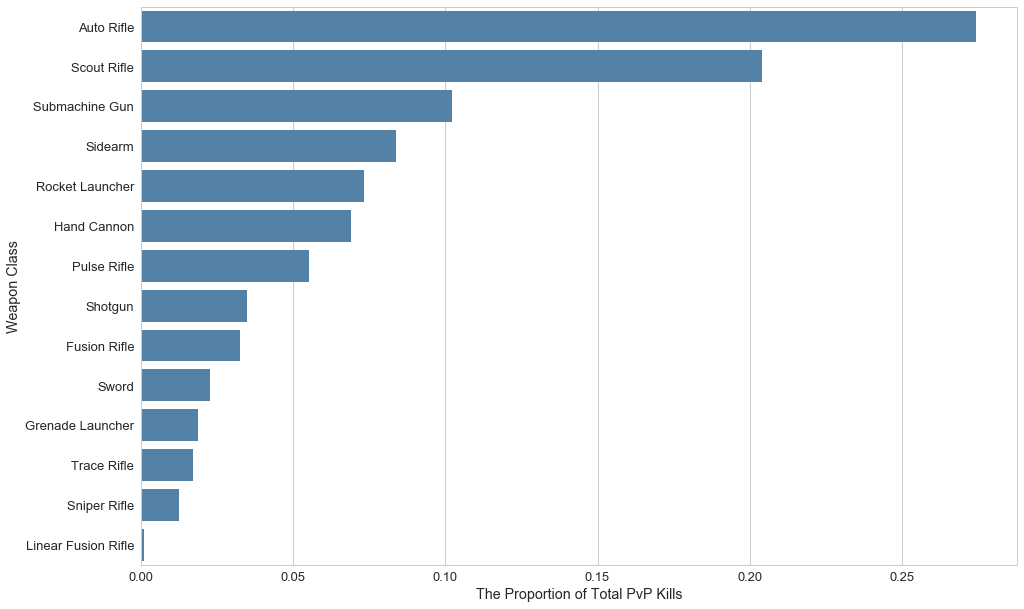

In [170]:
import seaborn as sns
sns.set(rc={'figure.figsize':(15.7,10.27)})
sns.set(font_scale=1.3)
sns.set_style("whitegrid")
ax=sns.barplot(x="%kills by weapon", y="weapon class", data=weapon_kills_stats,color="steelblue")
ax.set_xlabel('The Proportion of Total PvP Kills')
ax.set_ylabel('Weapon Class')

### Performance Box Plot 

In [129]:
dt_performance=final_cluster_clean[['Ability', 'Grenade', 'KDA', 'Melee',
       'Super', 'assists', 'avg_score_per_life', 'deaths', 'efficiency',
       'kills', 'score']]

In [130]:
dt_performance.head()

Ability   Grenade       KDA     Melee     Super   assists  \
0      0.0  0.888889  1.868613  0.111111  1.777778  4.444444   
1      0.0  0.300000  0.876166  0.700000  0.700000  3.100000   
2      0.0  0.250000  7.342560  0.500000  1.125000  6.500000   
3      0.0  0.750000  5.377976  0.500000  0.750000  1.875000   
4      0.0  0.642857  2.997785  0.214286  0.000000  6.500000   

   avg_score_per_life     deaths  efficiency      kills     score  
0            0.374140   9.222222    2.202215   9.222222  2.333333  
1            0.341880  11.400000    1.014219   8.200000  3.200000  
2            1.853720   4.625000    8.582341  16.500000  7.000000  
3            1.412450   4.375000    5.841518   9.500000  4.375000  
4            0.580972   7.571429    3.941951   9.428571  3.285714

Text(0,0.5,'The Value on each Match')

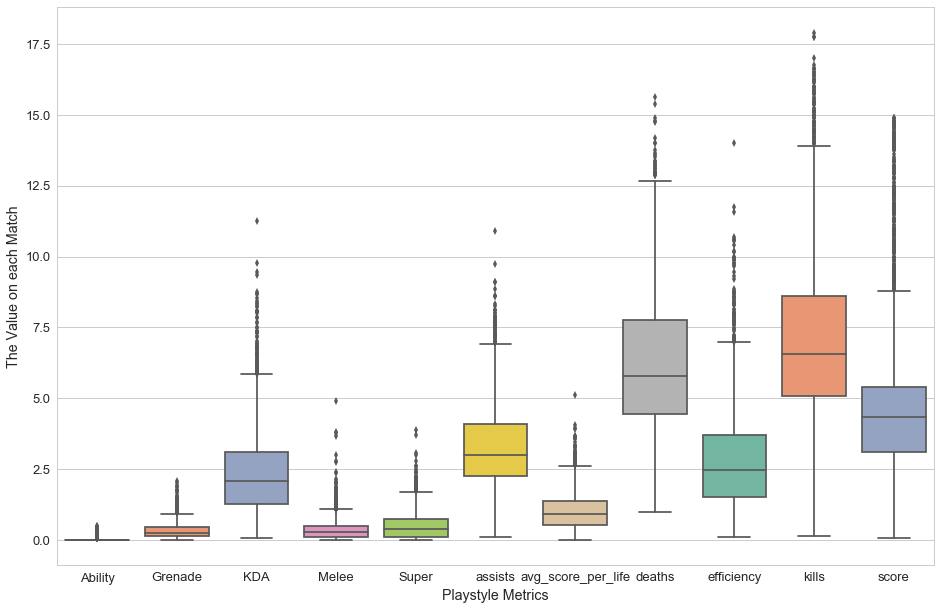

In [155]:
sns.set(rc={'figure.figsize':(15.7,10.27)})
sns.set(font_scale=1.3)
sns.set_style("whitegrid")
ax = sns.boxplot(data=dt_performance[(dt_performance["score"]<15)&(dt_performance["kills"]<18)], orient="v", palette="Set2",color="steelblue")
ax.set_xlabel('Playstyle Metrics')
ax.set_ylabel('The Value on each Match')



[(0, 16)]

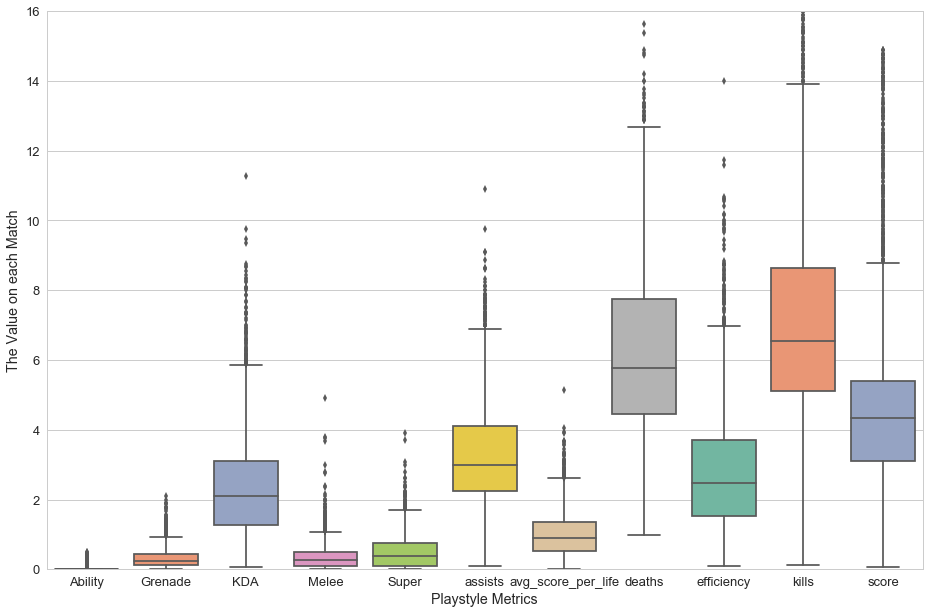

In [159]:
sns.set(rc={'figure.figsize':(15.7,10.27)})
sns.set(font_scale=1.3)
sns.set_style("whitegrid")
ax = sns.boxplot(data=dt_performance[(dt_performance["score"]<15)&(dt_performance["kills"]<18)], orient="v", palette="Set2",color="steelblue")
ax.set_xlabel('Playstyle Metrics')
ax.set_ylabel('The Value on each Match')
ax.set(ylim=(0, 16))


In [132]:
dt_performance.mean()

Ability               0.007689
Grenade               0.350948
KDA                   2.302936
Melee                 0.395389
Super                 0.569470
assists               3.383995
avg_score_per_life    1.147399
deaths                6.578934
efficiency            2.741398
kills                 7.502245
score                 6.433776
dtype: float64

In [134]:
mean_per_stats=pd.DataFrame(dt_performance.mean()).reset_index()
mean_per_stats.columns=["play style feature","avg value per match"]
mean_per_stats=mean_per_stats.sort_values("avg value per match",ascending=False)
mean_per_stats

play style feature  avg value per match
9                kills             7.502245
7               deaths             6.578934
10               score             6.433776
5              assists             3.383995
8           efficiency             2.741398
2                  KDA             2.302936
6   avg_score_per_life             1.147399
4                Super             0.569470
3                Melee             0.395389
1              Grenade             0.350948
0              Ability             0.007689

Text(0.5,0,'The Value on each Match')

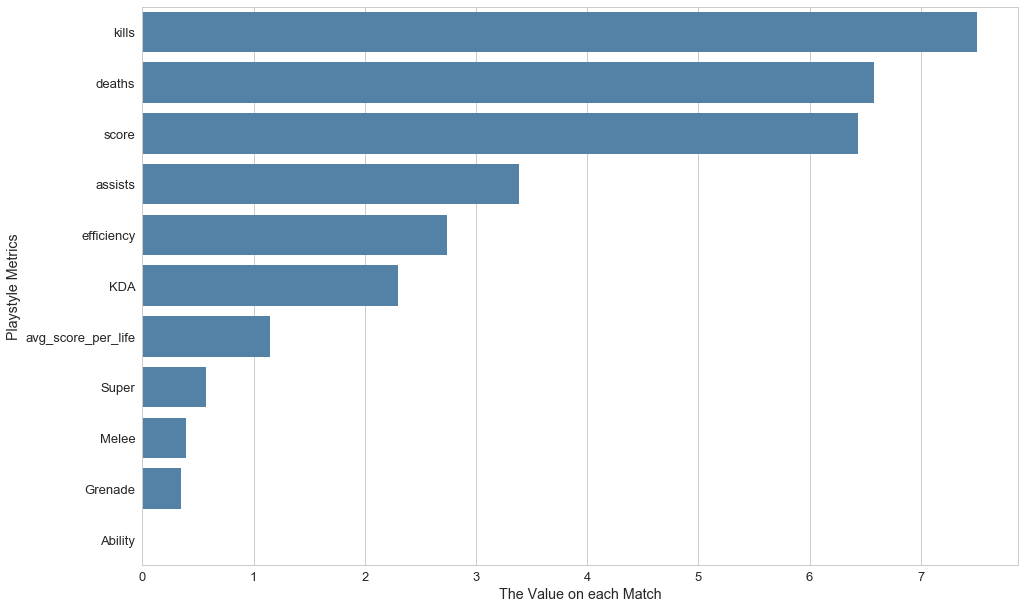

In [165]:
import seaborn as sns
sns.set(rc={'figure.figsize':(15.7,10.27)})
sns.set(font_scale=1.3)
sns.set_style("whitegrid")
ax=sns.barplot(x="avg value per match", y="play style feature", data=mean_per_stats,color="steelblue")
ax.set_ylabel('Playstyle Metrics')
ax.set_xlabel('The Value on each Match')

### <a id='replace'>Replace with the new clusters</a>

In [171]:
newset["performance_cluster"] = performance_cluster_std
newset["weapon_pro_cluster"] = weapon_cluster_std
newset.head()

/Users/wangziwen/anaconda/envs/python2.7/lib/python3.6/site-packages/ipykernel_launcher.py:1: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/wangziwen/anaconda/envs/python2.7/lib/python3.6/site-packages/ipykernel_launcher.py:2: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



playersID                                             teamID  \
0  2305843009260294880  2305843009260294880230584300926065511223058430...   
1  2305843009260301047  2305843009260301047230584300926407495723058430...   
2  2305843009260304802  2305843009260304802230584300926112491023058430...   
3  2305843009260306096  2305843009260306096230584300926893816923058430...   
4  2305843009260307017  2305843009260307017230584300926409646823058430...   

   performance_cluster  weapon_pro_cluster Character_Class  
0                    0                   6         Warlock  
1                    0                   6         Warlock  
2                    0                   6          Hunter  
3                    0                   2         Warlock  
4                    0                   6          Hunter

### <a id='team'>Team level</a>

#### <a id='team_all'>Performance + Weapon + Class  --> Weapon</a>

In [172]:
def teamall(df):
    df["values"] = 1
    table_weapon = df.pivot_table(index="teamID", columns="weapon_pro_cluster", values = "values",aggfunc=sum)
    table_char = df.pivot_table(index="teamID", columns="Character_Class", values = "values",aggfunc=sum)
    table_per = df.pivot_table(index="teamID", columns="performance_cluster", values = "values",aggfunc=sum)
    table_weapon = table_weapon.fillna(0)
    table_char = table_char.fillna(0)
    table_per = table_per.fillna(0)
    finalresult = pd.concat([table_weapon, table_char,table_per], axis=1).reset_index()
    return finalresult


In [173]:
def changeweight(df,char_weight):
    df[["Hunter","Titan","Warlock"]] = df[["Hunter","Titan","Warlock"]] * char_weight
    return df

all_dim = teamall(newset)
all_dim = changeweight(all_dim,1.5)
all_dim.columns = ['teamID', 'Weapon_0', 'Weapon_1',"Weapon_2","Weapon_3","Weapon_4","Weapon_5","Weapon_6",
                  "Hunter","Titan","Warlock",
                  "Per_0","Per_1","Per_2","Per_3","Per_4"]

/Users/wangziwen/anaconda/envs/python2.7/lib/python3.6/site-packages/ipykernel_launcher.py:2: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



#### <a id='team_wc'>Weapon + Classs --> Playstyle</a>

In [174]:
def teamweaponandchar(df):
    df["values"] = 1
    table_weapon = df.pivot_table(index="teamID", columns="weapon_pro_cluster", values = "values",aggfunc=sum)
    table_char = df.pivot_table(index="teamID", columns="Character_Class", values = "values",aggfunc=sum)
    table_weapon = table_weapon.fillna(0)
    table_char = table_char.fillna(0)
    finalresult = pd.concat([table_weapon, table_char], axis=1).reset_index()
    return finalresult

weapon_and_char = teamweaponandchar(newset)
weapon_and_char = changeweight(weapon_and_char,1.5)
weapon_and_char.head()

/Users/wangziwen/anaconda/envs/python2.7/lib/python3.6/site-packages/ipykernel_launcher.py:2: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



teamID    0    1    2    3    4  \
0  2305843009260294880230584300926065511223058430...  1.0  1.0  0.0  0.0  0.0   
1  2305843009260301047230584300926407495723058430...  3.0  0.0  0.0  0.0  0.0   
2  2305843009260304802230584300926112491023058430...  1.0  0.0  0.0  0.0  0.0   
3  2305843009260306096230584300926893816923058430...  2.0  1.0  1.0  0.0  0.0   
4  2305843009260307017230584300926409646823058430...  0.0  0.0  1.0  0.0  0.0   

     5    6  Hunter  Titan  Warlock  
0  0.0  2.0     0.0    3.0      3.0  
1  0.0  1.0     0.0    1.5      4.5  
2  2.0  1.0     4.5    1.5      0.0  
3  0.0  0.0     1.5    3.0      1.5  
4  0.0  3.0     3.0    1.5      1.5

#### <a id='team_dist'>Team Distance </a>

In [175]:
def get_dist(dimensions):
    df = pd.DataFrame(squareform(pdist(dimensions.iloc[:, 1:],metric = 'cityblock')), 
                     columns=dimensions.teamID.unique(), index=dimensions.teamID.unique())\
                     .reset_index()
    index = df.iloc[:,0]
    df = df.iloc[:,1:]
    df.values[[np.arange(len(df))]*2] = 99999
    df.insert(0,"index",index)
    return df

In [176]:
dist_all = get_dist(all_dim)
dist_wc = get_dist(weapon_and_char)

#### <a id='findnn'>Find NN for teams </a>

In [177]:
def findnn(distance_df,n):
    idx = np.argsort(distance_df, axis=0)[:n]
    idx = idx.drop('index', 1)
    dfList = distance_df['index'].tolist()
    dfList = distance_df
    IdxDict=dict(enumerate(dfList))
    idx.replace(IdxDict,inplace=True)
    return idx

In [178]:
### Using weapon+class to recommend performance
resultteams_all = findnn(dist_all,5) 
resultteams_all

2305843009260294880230584300926065511223058430092657851422305843009265925242  \
0  2305843009261536900230584300926324438223058430...                             
1  2305843009260618250230584300926089895323058430...                             
2  2305843009261077549230584300926156261223058430...                             
3  2305843009265887920230584300926595080023058430...                             
4  2305843009265872292230584300926702836623058430...                             

  2305843009260301047230584300926407495723058430092908951392305843009290965137  \
0  2305843009269912259230584300929220783523058430...                             
1  2305843009261956687230584300926726345523058430...                             
2  2305843009263244382230584300927006533823058430...                             
3  2305843009261868610230584300926193820723058430...                             
4  2305843009260688946230584300926280128123058430...                             

  2305843009260304802230584300926112491023058430092627147842305843009269893032  \
0  2305843009260589621230584300926136938123058430...                             
1  2305843009269921820230584300929147653123058430...                             
2  2305843009264525649230584300927932113023058430...                             
3  2305843009265768537230584300926869878723058430...                             
4  2305843009267425390230584300926746557123058430...                             

  2305843009260306096230584300926893816923058430092689547272305843009284689157  \
0  2305843009270211439230584300927819019823058430...                             
1  2305843009260495958230584300926189529623058430...                             
2  2305843009263035068230584300926333051323058430...                             
3  2305843009262121284230584300926313512023058430...                             
4  2305843009267982972230584300929095525023058430...                             

  2305843009260307017230584300926409646823058430092643115142305843009267824705  \
0  2305843009262924299230584300926905473223058430...                             
1  2305843009262029854230584300926442821823058430...                             
2  2305843009283494720230584300928388544523058430...                             
3  2305843009261394267230584300926153414723058430...                             
4  2305843009268227670230584300927003004523058430...                             

  2305843009260309699230584300926052035523058430092659082862305843009283578425  \
0  2305843009262768241230584300926615934423058430...                             
1  2305843009262283456230584300926797848923058430...                             
2  2305843009265104619230584300926902325723058430...                             
3  2305843009262903674230584300926354708623058430...                             
4  2305843009260762443230584300926269936623058430...                             

  2305843009260313050230584300926156342923058430092662893912305843009294828645  \
0  2305843009260893388230584300926224991923058430...                             
1  2305843009263030943230584300926380031223058430...                             
2  2305843009263867895230584300926715844923058430...                             
3  2305843009263435061230584300926495574523058430...                             
4  2305843009260366010230584300926060533723058430...                             

  2305843009260314368230584300928558757523058430092859879742305843009294145614  \
0  2305843009265343488230584300926638368923058430...                             
1  2305843009263459861230584300927285949723058430...                             
2  2305843009261612596230584300926211999423058430...                             
3  2305843009262434484230584300927739431023058430...                             
4  2305843009264888098230584300927903421923058430...                             

  23058430092603149202305843009261194808230584300926421564

In [179]:
resultteams_wc = findnn(dist_wc,5) 
resultteams_wc

2305843009260294880230584300926065511223058430092657851422305843009265925242  \
0  2305843009261543281230584300927191513823058430...                             
1  2305843009263816420230584300926630311723058430...                             
2  2305843009265983712230584300926752462723058430...                             
3  2305843009271469179230584300927843617123058430...                             
4  2305843009260618250230584300926089895323058430...                             

  2305843009260301047230584300926407495723058430092908951392305843009290965137  \
0  2305843009262134847230584300926251629923058430...                             
1  2305843009261868610230584300926193820723058430...                             
2  2305843009263244382230584300927006533823058430...                             
3  2305843009261956687230584300926726345523058430...                             
4  2305843009261681740230584300927153791523058430...                             

  2305843009260304802230584300926112491023058430092627147842305843009269893032  \
0  2305843009262029859230584300929599465623058430...                             
1  2305843009261279468230584300927305527423058430...                             
2  2305843009262647617230584300927056024423058430...                             
3  2305843009269921820230584300929147653123058430...                             
4  2305843009260589621230584300926136938123058430...                             

  2305843009260306096230584300926893816923058430092689547272305843009284689157  \
0  2305843009260719268230584300926183370023058430...                             
1  2305843009262121284230584300926313512023058430...                             
2  2305843009261380749230584300929209502423058430...                             
3  2305843009260655380230584300928982756023058430...                             
4  2305843009261493391230584300926383692123058430...                             

  2305843009260307017230584300926409646823058430092643115142305843009267824705  \
0  2305843009260314368230584300928558757523058430...                             
1  2305843009264508024230584300926467770223058430...                             
2  2305843009262924299230584300926905473223058430...                             
3  2305843009261973826230584300926500092823058430...                             
4  2305843009260347087230584300926174650123058430...                             

  2305843009260309699230584300926052035523058430092659082862305843009283578425  \
0  2305843009264244009230584300927691543623058430...                             
1  2305843009262283456230584300926797848923058430...                             
2  2305843009262768241230584300926615934423058430...                             
3  2305843009260688946230584300926280128123058430...                             
4  2305843009262334234230584300926371078623058430...                             

  2305843009260313050230584300926156342923058430092662893912305843009294828645  \
0  2305843009263446094230584300926428657623058430...                             
1  2305843009260767050230584300926236683923058430...                             
2  2305843009265068792230584300926807867323058430...                             
3  2305843009262018927230584300926287414123058430...                             
4  2305843009261988200230584300926828253623058430...                             

  2305843009260314368230584300928558757523058430092859879742305843009294145614  \
0  2305843009261958378230584300926292572523058430...                             
1  2305843009276869989230584300928460896223058430...                             
2  2305843009260744850230584300926086496623058430...                             
3  2305843009261612596230584300926211999423058430...                             
4  2305843009261765732230584300926374865023058430...                             

  23058430092603149202305843009261194808230584300926421564

#### <a id='target'>Choose the target team </a>

In [217]:
def choosetarget(data,resultteams):
    target = textwrap.wrap(data,19)
    testteam = resultteams.iloc[:,resultteams.\
                                columns.\
                                get_loc(data)]
    return testteam

In [218]:
#targetteam = "2305843009264404279230584300927803779723058430092902852642305843009291975432"
targetteam = "2305843009264657286230584300926604372523058430092696024442305843009270322137"

target = textwrap.wrap(targetteam,19)

In [219]:
testteam_all = choosetarget(targetteam,resultteams_all)
testteam_all

0    2305843009261034053230584300926191403923058430...
1    2305843009262480257230584300926264821423058430...
2    2305843009263893462230584300927236656023058430...
3    2305843009260616322230584300926123755423058430...
4    2305843009261030218230584300926219348623058430...
Name: 2305843009264657286230584300926604372523058430092696024442305843009270322137, dtype: object

In [220]:
testteam_wc = choosetarget(targetteam,resultteams_wc)
testteam_wc

0    2305843009261034053230584300926191403923058430...
1    2305843009263893462230584300927236656023058430...
2    2305843009263472777230584300926351209323058430...
3    2305843009263422847230584300926348287523058430...
4    2305843009263353975230584300926470283123058430...
Name: 2305843009264657286230584300926604372523058430092696024442305843009270322137, dtype: object

#### <a id='winloss'>Find the team with highest win-loss ratio </a>

In [221]:
def getWinloss(testteam):
    df = pd.DataFrame(np.array(testteam))
    df.columns = ['teamID']
    df_merge = pd.merge(df,winloss,"left",on="teamID")
    finalteamid = df_merge.sort_values("Wins", ascending = False).iloc[0,0]
    finalteamsplit = textwrap.wrap(finalteamid,19)
    return finalteamsplit,finalteamid

In [222]:
test_all_win =getWinloss(testteam_all)

In [223]:
test_all_win

(['2305843009262480257',
  '2305843009262648214',
  '2305843009268358411',
  '2305843009270775032'],
 '2305843009262480257230584300926264821423058430092683584112305843009270775032')

In [224]:
test_wc_win = getWinloss(testteam_wc)
test_wc_win

(['2305843009263422847',
  '2305843009263482875',
  '2305843009272548894',
  '2305843009273714108'],
 '2305843009263422847230584300926348287523058430092725488942305843009273714108')

#### <a id='learning'>Find the team with highest learning rate </a>

In [225]:
def getLearning(data, metrics):
    df = pd.DataFrame(np.array(data))
    df.columns = ['teamID']
    df_merge = pd.merge(df,learning,"left",on="teamID")
    finalteamid = df_merge.sort_values(metrics, ascending = False).iloc[0,0]
    #finaltemp = df_merge.sort_values(metrics, ascending = False)
    finalteamsplit = textwrap.wrap(finalteamid,19)
    return finalteamsplit,finalteamid

In [226]:
test_all_lr = getLearning(testteam_all, "lr_KDA")
test_all_lr

(['2305843009261030218',
  '2305843009262193486',
  '2305843009262440518',
  '2305843009320706708'],
 '2305843009261030218230584300926219348623058430092624405182305843009320706708')

In [227]:
test_wc_lr  = getLearning(testteam_wc, "lr_KDA")
test_wc_lr

(['2305843009261034053',
  '2305843009261914039',
  '2305843009261926183',
  '2305843009264323396'],
 '2305843009261034053230584300926191403923058430092619261832305843009264323396')

### <a id='players'>Players to Players</a>

#### <a id='player_wc'>Players weapon + class </a>

In [228]:
def getplayerdist(df):
    df["values"] = 1
    table_weapon = df.pivot_table(index="playersID", columns="weapon_pro_cluster", values = "values",aggfunc=sum)
    table_char = df.pivot_table(index="playersID", columns="Character_Class", values = "values",aggfunc=sum)
    #table_per = df.pivot_table(index="playersID", columns="performance_cluster", values = "values",aggfunc=sum)
    table_weapon = table_weapon.fillna(0)
    table_char = table_char.fillna(0)
    #table_per = table_per.fillna(0)
    finalresult = pd.concat([table_weapon, table_char], axis=1).reset_index()
    return finalresult

In [229]:
playersdist_wc = getplayerdist(newset)

/Users/wangziwen/anaconda/envs/python2.7/lib/python3.6/site-packages/ipykernel_launcher.py:2: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



In [230]:
### Increase weights of class
def changeweight(df,weight):
    df[["Hunter","Titan","Warlock"]] = df[["Hunter","Titan","Warlock"]]*weight
    return df
playersdist_wc = changeweight(playersdist_wc,2)

#### <a id='player_all'>Players playstyle + weapon + class </a>

In [231]:
def getplayerdist_all(df):
    df["values"] = 1
    table_weapon = df.pivot_table(index="playersID", columns="weapon_pro_cluster", values = "values",aggfunc=sum)
    table_char = df.pivot_table(index="playersID", columns="Character_Class", values = "values",aggfunc=sum)
    table_per = df.pivot_table(index="playersID", columns="performance_cluster", values = "values",aggfunc=sum)
    table_weapon = table_weapon.fillna(0)
    table_char = table_char.fillna(0)
    table_per = table_per.fillna(0)
    finalresult = pd.concat([table_weapon, table_char,table_per], axis=1).reset_index()
    return finalresult

In [232]:
playersdist_all = getplayerdist_all(newset)

/Users/wangziwen/anaconda/envs/python2.7/lib/python3.6/site-packages/ipykernel_launcher.py:2: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



In [233]:
### Increase weights of class
def changeweight(df,weight):
    df[["Hunter","Titan","Warlock"]] = df[["Hunter","Titan","Warlock"]]*weight
    return df
playersdist_all = changeweight(playersdist_all,2)
playersdist_all.head()

playersID    0    1    2    3    4    5    6  Hunter  Titan  \
0  2305843009260294880  0.0  0.0  0.0  0.0  0.0  0.0  1.0     0.0    0.0   
1  2305843009260301047  0.0  0.0  0.0  0.0  0.0  0.0  1.0     0.0    0.0   
2  2305843009260304802  0.0  0.0  0.0  0.0  0.0  0.0  1.0     2.0    0.0   
3  2305843009260306096  0.0  0.0  1.0  0.0  0.0  0.0  0.0     0.0    0.0   
4  2305843009260307017  0.0  0.0  0.0  0.0  0.0  0.0  1.0     2.0    0.0   

   Warlock    0    1    2    3    4  
0      2.0  1.0  0.0  0.0  0.0  0.0  
1      2.0  1.0  0.0  0.0  0.0  0.0  
2      0.0  1.0  0.0  0.0  0.0  0.0  
3      2.0  1.0  0.0  0.0  0.0  0.0  
4      0.0  1.0  0.0  0.0  0.0  0.0

In [234]:
playersdist_all.columns = ['playersID', 'Weapon_0', 'Weapon_1',"Weapon_2","Weapon_3","Weapon_4","Weapon_5","Weapon_6",
                  "Hunter","Titan","Warlock",
                  "Per_0","Per_1","Per_2","Per_3","Per_4"]
playersdist_all.head()

playersID  Weapon_0  Weapon_1  Weapon_2  Weapon_3  Weapon_4  \
0  2305843009260294880       0.0       0.0       0.0       0.0       0.0   
1  2305843009260301047       0.0       0.0       0.0       0.0       0.0   
2  2305843009260304802       0.0       0.0       0.0       0.0       0.0   
3  2305843009260306096       0.0       0.0       1.0       0.0       0.0   
4  2305843009260307017       0.0       0.0       0.0       0.0       0.0   

   Weapon_5  Weapon_6  Hunter  Titan  Warlock  Per_0  Per_1  Per_2  Per_3  \
0       0.0       1.0     0.0    0.0      2.0    1.0    0.0    0.0    0.0   
1       0.0       1.0     0.0    0.0      2.0    1.0    0.0    0.0    0.0   
2       0.0       1.0     2.0    0.0      0.0    1.0    0.0    0.0    0.0   
3       0.0       0.0     0.0    0.0      2.0    1.0    0.0    0.0    0.0   
4       0.0       1.0     2.0    0.0      0.0    1.0    0.0    0.0    0.0   

   Per_4  
0    0.0  
1    0.0  
2    0.0  
3    0.0  
4    0.0

#### <a id='player_dist'>Players distance </a>

In [235]:
def getPlayerDistances(team1, team2, playerclusters_df):
    playerclusters_df1 = playerclusters_df[playerclusters_df.playersID.isin(team1)]
    playerclusters_df2 = playerclusters_df[playerclusters_df.playersID.isin(team2)]
    
    playerdist = pd.DataFrame(cdist(playerclusters_df1.iloc[:, 1:], playerclusters_df2.iloc[:, 1:],
                                            metric = 'cityblock'), \
                     columns=playerclusters_df2.playersID, index=playerclusters_df1.playersID)\
                    .reset_index()
    playerdist.index.names = ['index']

    return playerdist

In [236]:
def getDistmat(test,playersdist):
    tm2 = test[0]
    tm1 = target
    distmat = getPlayerDistances(tm1, tm2, playersdist)
    return distmat

In [237]:
target

['2305843009264657286',
 '2305843009266043725',
 '2305843009269602444',
 '2305843009270322137']

### change recommend target 

In [238]:
#target=['2305843009264404279','2305843009278037797','2305843009290285264','2305843009291975432']

#### <a id='player_map'>Players to players mapping </a>

In [239]:
def getDistList(mapping, dist_df):
    distlist = []
#     for k,v in mapping.items():
#         dist = dist_df[dist_df.playersID == k, v]
#         distlist.append(dist)
    distlist = list(dist_df[dist_df["playersID"] == tup[0]][tup[1]] for tup in mapping)
    newdistlist = [item for items in distlist for item in items]
    return newdistlist
    

In [240]:
def sortByDist(mapped):
    mapped.sort(key = lambda y: y[1])
    #print(mapped)
    return mapped

In [241]:
''' dist_df - is the created distance matrix with players of team 1 as rows, team 2 as columns
    numToSum - The number of best matched players to consider when deciding the best possible mapping.
                (eg. All 4 could result in 4 players not matched well, but if used to the first 2 could match perfectly
                but next 2 poorly, but at least highly relevant for fist 2)
'''
def getPlayerMapping(dist_df, numToSum):
    mapping = {}
    permuts = list(itertools.permutations(dist_df.playersID))
    #for tm1player in dist_df.playersID:
    team2 = list(dist_df.iloc[:, 1:].columns.values)
    newdf = pd.DataFrame({"Team1":permuts})
    newdf["Mapping"] = newdf.apply(lambda x: list(list(zip(x["Team1"], team2))[:]), axis = 1)
    newdf["Dists"] = newdf.apply(lambda x: getDistList(x["Mapping"], dist_df), axis = 1)
#   print(newdf)
    newdf["MapWithDist"] = newdf.apply(lambda x: list(list(zip(x["Mapping"], x["Dists"]))[:]), axis = 1)
    #print(newdf["MapWithDist"][0], "\n\n")
    newdf["SortedByDist"] = newdf["MapWithDist"].apply(lambda x: sortByDist(x))
    #print(newdf)
    newdf["PureMappingFinal"] = newdf["SortedByDist"].apply(lambda x: [(tup[0][0], tup[0][1]) for tup in x])
    #print(newdf["PureMappingFinal"][0])
    newdf["SumDist"] = newdf.apply(lambda x: sum(tup[1] for tup in x["SortedByDist"][0:(numToSum - 1)]), axis = 1)
    #print(newdf)
    newdf["AllPlayersDist"] = newdf.apply(lambda x: sum(tup[1] for tup in x["SortedByDist"]), axis = 1)
    #print(newdf)
    mindist_idx = newdf.SumDist.idxmin
    finalmapping = newdf["PureMappingFinal"][mindist_idx]
    finalsum = newdf["SumDist"][mindist_idx]
    finaltotalsum = newdf["AllPlayersDist"][mindist_idx]
    
    #ONLY NEED THE FIRST ELEMENT, BUT SECOND TELLS US WHAT THE TOTAL RELEVANT DISTANCE WAS, THIRD TELLS US TOTAL
    #DISTANCE FOR ALL 4 PLAYERS
    return finalmapping

        

### <a id='rec'>Final Recommendation</a>

#### <a id='rec'>Recommendation for playstyle based on Weapon + Class based on learningrate</a>

In [266]:
distmat = getDistmat(test_wc_lr, playersdist_wc)
distmat
playerresult = getPlayerMapping(distmat,2)
playerresult

[(2305843009269602444, 2305843009264323396),
 (2305843009266043725, 2305843009261914039),
 (2305843009270322137, 2305843009261926183),
 (2305843009264657286, 2305843009261034053)]

In [270]:
playersdist_wc.head()

playersID    0    1    2    3    4    5    6  Hunter  Titan  \
0  2305843009260294880  0.0  0.0  0.0  0.0  0.0  0.0  1.0     0.0    0.0   
1  2305843009260301047  0.0  0.0  0.0  0.0  0.0  0.0  1.0     0.0    0.0   
2  2305843009260304802  0.0  0.0  0.0  0.0  0.0  0.0  1.0     2.0    0.0   
3  2305843009260306096  0.0  0.0  1.0  0.0  0.0  0.0  0.0     0.0    0.0   
4  2305843009260307017  0.0  0.0  0.0  0.0  0.0  0.0  1.0     2.0    0.0   

   Warlock  
0      2.0  
1      2.0  
2      0.0  
3      2.0  
4      0.0

In [271]:
distmat

playersID            playersID  2305843009261034053  2305843009261914039  \
index                                                                      
0          2305843009264657286                  6.0                  2.0   
1          2305843009266043725                  6.0                  2.0   
2          2305843009269602444                  6.0                  2.0   
3          2305843009270322137                  6.0                  6.0   

playersID  2305843009261926183  2305843009264323396  
index                                                
0                          6.0                  2.0  
1                          6.0                  2.0  
2                          6.0                  0.0  
3                          2.0                  6.0

In [272]:
playstyle.head()

TEAMID            PLAYERSID  \
0  2305843009260294880230584300926065511223058430...  2305843009260294880   
1  2305843009260294880230584300926065511223058430...  2305843009260655112   
2  2305843009260294880230584300926065511223058430...  2305843009265785142   
3  2305843009260294880230584300926065511223058430...  2305843009265925242   
4  2305843009260301047230584300926407495723058430...  2305843009260301047   

    Grenade     Melee   assists   Ability     Super  
0  0.888889  0.111111  4.444444  0.000000  1.777778  
1  1.222222  0.000000  7.000000  0.000000  2.000000  
2  0.444444  0.111111  5.444444  0.222222  0.666667  
3  0.666667  0.666667  5.666667  0.000000  1.333333  
4  0.300000  0.700000  3.100000  0.000000  0.700000

In [273]:
def getPlaystyle(data, test):
    df = pd.DataFrame(list(data))
    df.columns = ['targetplayersID','playersID']
    
    df['teamID'] = test[1]
    df['targetteamID'] = targetteam
    
    playstyle.columns = ["TEAMID","PLAYERSID","Grenade","Melee","assists","Ability","Super"]
    #playstyle["TEAMID"] = str(playstyle["TEAMID"])
    
    df_merge = pd.merge(df,playstyle,"left", left_on=["teamID","playersID"], right_on = ["TEAMID","PLAYERSID"] )
    
    df_merge2= pd.merge(df,playstyle,left_on = ["targetplayersID","targetteamID"], right_on = ["PLAYERSID","TEAMID"],
                       how = "left")
    
    final_merge = pd.merge(df_merge,df_merge2, "left", on = ["targetplayersID"])
    final_result = df
    df["Grenade_diff"] = final_merge["Grenade_x"] - final_merge["Grenade_y"]
    df["Melee_diff"] = final_merge["Melee_x"] - final_merge["Melee_y"]
    df["assists_diff"] = final_merge["assists_x"] - final_merge["assists_y"]
    df["Ability_diff"] = final_merge["Ability_x"] - final_merge["Ability_y"]
    df["Super_diff"] = final_merge["Super_x"] - final_merge["Super_y"]
    del df["targetteamID"]
    return df

In [275]:
rec=getPlaystyle(playerresult,test_wc_lr)
rec

targetplayersID            playersID  \
0  2305843009269602444  2305843009264323396   
1  2305843009266043725  2305843009261914039   
2  2305843009270322137  2305843009261926183   
3  2305843009264657286  2305843009261034053   

                                              teamID  Grenade_diff  \
0  2305843009261034053230584300926191403923058430...     -0.086957   
1  2305843009261034053230584300926191403923058430...      0.157609   
2  2305843009261034053230584300926191403923058430...     -0.391304   
3  2305843009261034053230584300926191403923058430...     -0.217391   

   Melee_diff  assists_diff  Ability_diff  Super_diff  
0   -0.483696     -0.744565         0.000    0.000000  
1   -0.005435     -1.766304         0.000   -0.483696  
2   -0.130435     -2.548913         0.125   -0.565217  
3   -0.005435     -0.331522         0.000    0.375000

In [279]:
list_A=list(rec["targetplayersID"])+list(rec["playersID"])

#### <a id='rec'>Recommendation for playstyle based on Weapon + Class based on win ratio</a> 

In [280]:
distmat = getDistmat(test_all_win, playersdist_wc)
distmat
playerresult = getPlayerMapping(distmat,2)
playerresult
rec=getPlaystyle(playerresult,test_all_win)
rec

targetplayersID            playersID  \
0  2305843009264657286  2305843009270775032   
1  2305843009270322137  2305843009268358411   
2  2305843009266043725  2305843009262480257   
3  2305843009269602444  2305843009262648214   

                                              teamID  Grenade_diff  \
0  2305843009262480257230584300926264821423058430...      0.407609   
1  2305843009262480257230584300926264821423058430...     -0.016304   
2  2305843009262480257230584300926264821423058430...      0.157609   
3  2305843009262480257230584300926264821423058430...     -0.086957   

   Melee_diff  assists_diff  Ability_diff  Super_diff  
0    0.119565      0.793478           0.0    0.125000  
1   -0.130435     -0.298913           0.0   -0.065217  
2   -0.130435     -1.516304           0.0   -0.358696  
3   -0.483696      0.380435           0.0    0.250000

In [281]:
list_B=list(rec["targetplayersID"])+list(rec["playersID"])

#### <a id='rec'>Recommendation for weapon based on Playstyle + Weapon + Class based on learning rate</a>

In [258]:
distmat = getDistmat(test_wc_lr, playersdist_wc)
distmat
playerresult = getPlayerMapping(distmat,2)
playerresult

[(2305843009269602444, 2305843009264323396),
 (2305843009266043725, 2305843009261914039),
 (2305843009270322137, 2305843009261926183),
 (2305843009264657286, 2305843009261034053)]

In [259]:
def getWeapondf(data, test):
    df = pd.DataFrame(list(data))
    df.columns = ['targetplayersID','playersID']
    df['teamID'] = test[1]
    return df

In [260]:
weapondf = getWeapondf(playerresult,test_all_win)
weapondf

targetplayersID            playersID  \
0  2305843009269602444  2305843009264323396   
1  2305843009266043725  2305843009261914039   
2  2305843009270322137  2305843009261926183   
3  2305843009264657286  2305843009261034053   

                                              teamID  
0  2305843009262480257230584300926264821423058430...  
1  2305843009262480257230584300926264821423058430...  
2  2305843009262480257230584300926264821423058430...  
3  2305843009262480257230584300926264821423058430...

In [261]:
def getWeapon(df):
    df2=df.copy()
    new_dt=df2[["teamID","playersID"]]
    weapon_1=[]
    weapon_2=[]
    weapon_3=[] 
    for playersID in list(new_dt["playersID"]):
        if len(referenceid_list[str(playersID)])>2:
            weapon_1.append(weapon_list[str(referenceid_list[str(playersID)][0])])
            weapon_2.append(weapon_list[str(referenceid_list[str(playersID)][1])])
            weapon_3.append(weapon_list[str(referenceid_list[str(playersID)][2])])
        elif len(referenceid_list[str(playersID)])==2:
            weapon_1.append(weapon_list[str(referenceid_list[str(playersID)][0])])
            weapon_2.append(weapon_list[str(referenceid_list[str(playersID)][1])])
            weapon_3.append("NA")
        else:
            weapon_1.append(weapon_list[str(referenceid_list[str(playersID)][0])])
            weapon_2.append("NA")
            weapon_3.append("NA")
    df2["weapon_1"]=weapon_1
    df2["weapon_2"]=weapon_2
    df2["weapon_3"]=weapon_3
    return df2
weaponrec = getWeapon(weapondf)
weaponrec

targetplayersID            playersID  \
0  2305843009269602444  2305843009264323396   
1  2305843009266043725  2305843009261914039   
2  2305843009270322137  2305843009261926183   
3  2305843009264657286  2305843009261034053   

                                              teamID  \
0  2305843009262480257230584300926264821423058430...   
1  2305843009262480257230584300926264821423058430...   
2  2305843009262480257230584300926264821423058430...   
3  2305843009262480257230584300926264821423058430...   

                                  weapon_1  \
0        [Merciless, Fusion Rifle, Exotic]   
1     [Galliard-42, Auto Rifle, Legendary]   
2  [Lincoln Green, Pulse Rifle, Legendary]   
3    [Vigilance Wing, Pulse Rifle, Exotic]   

                                       weapon_2  \
0      [Adjudicator, Submachine Gun, Legendary]   
1         [Uriel's Gift, Auto Rifle, Legendary]   
2  [Wicked Sister, Grenade Launcher, Legendary]   
3        [MIDA Multi-Tool, Scout Rifle, Exotic]   

                                      weapon_3  
0        [Uriel's Gift, Auto Rifle, Legendary]  
1  [Out of Options, Submachine Gun, Legendary]  
2     [Death Adder, Submachine Gun, Legendary]  
3          [Prosecutor, Auto Rifle, Legendary]

In [282]:
list_C=list(weaponrec["targetplayersID"])+list(weaponrec["playersID"])

#### <a id='rec'>Recommendation for weapon based on Playstyle + Weapon + Class based on win loss</a>

In [262]:
distmat = getDistmat(test_all_win, playersdist_wc)
distmat
playerresult = getPlayerMapping(distmat,2)
playerresult
getPlaystyle(playerresult,test_all_win)
weapondf = getWeapondf(playerresult,test_all_win)
weaponrec = getWeapon(weapondf)
weaponrec

targetplayersID            playersID  \
0  2305843009264657286  2305843009270775032   
1  2305843009270322137  2305843009268358411   
2  2305843009266043725  2305843009262480257   
3  2305843009269602444  2305843009262648214   

                                              teamID  \
0  2305843009262480257230584300926264821423058430...   
1  2305843009262480257230584300926264821423058430...   
2  2305843009262480257230584300926264821423058430...   
3  2305843009262480257230584300926264821423058430...   

                                   weapon_1  \
0  [Seven-Six-Five, Scout Rifle, Legendary]   
1     [Jiangshi AR4, Auto Rifle, Legendary]   
2     [Uriel's Gift, Auto Rifle, Legendary]   
3      [A Sudden Death, Shotgun, Legendary]   

                                      weapon_2  \
0     [The Long Walk, Sniper Rifle, Legendary]   
1              [Last Hope, Sidearm, Legendary]   
2        [Tone Patrol, Scout Rifle, Legendary]   
3  [Phosphorus MG4, Submachine Gun, Legendary]   

                                      weapon_3  
0  [Phosphorus MG4, Submachine Gun, Legendary]  
1             [Aachen-LR2, Sniper Rifle, Rare]  
2       [Antiope-D, Submachine Gun, Legendary]  
3        [Origin Story, Auto Rifle, Legendary]

In [283]:
list_D=list(weaponrec["targetplayersID"])+list(weaponrec["playersID"])

### The cluster labels of players

In [284]:
final_ply_list=list(set(list_A+list_B+list_C+list_D))
final_ply_list

[2305843009262480257,
 2305843009264323396,
 2305843009261034053,
 2305843009264657286,
 2305843009261926183,
 2305843009268358411,
 2305843009269602444,
 2305843009266043725,
 2305843009262648214,
 2305843009261914039,
 2305843009270775032,
 2305843009270322137]

In [287]:
newset[newset["playersID"] .isin(final_ply_list)]

playersID                                             teamID  \
289   2305843009261034053  2305843009261034053230584300926191403923058430...   
612   2305843009261914039  2305843009261034053230584300926191403923058430...   
619   2305843009261926183  2305843009261034053230584300926191403923058430...   
832   2305843009262480257  2305843009262480257230584300926264821423058430...   
894   2305843009262648214  2305843009262480257230584300926264821423058430...   
1341  2305843009264323396  2305843009261034053230584300926191403923058430...   
1428  2305843009264657286  2305843009264657286230584300926604372523058430...   
1718  2305843009266043725  2305843009264657286230584300926604372523058430...   
2066  2305843009268358411  2305843009262480257230584300926264821423058430...   
2234  2305843009269602444  2305843009264657286230584300926604372523058430...   
2360  2305843009270322137  2305843009264657286230584300926604372523058430...   
2430  2305843009270775032  2305843009262480257230584300926264821423058430...   

      performance_cluster  weapon_pro_cluster Character_Class  values  
289                     1                   6           Titan       1  
612                     1                   6          Hunter       1  
619                     4                   6         Warlock       1  
832                     1                   1         Warlock       1  
894                     1                   1           Titan       1  
1341                    1                   5          Hunter       1  
1428                    1                   1          Hunter       1  
1718                    1                   0          Hunter       1  
2066                    1                   4         Warlock       1  
2234                    1                   5          Hunter       1  
2360                    1                   0         Warlock       1  
2430                    1                   1          Hunter       1

### Players History 

In [290]:
# playstyle
plystyle=newtable[['playersID', 'teamID','Character_Class','Ability', 'Grenade', 'Melee',
       'Super', 'assists']]
plystyle[plystyle["playersID"].isin(final_ply_list)]

playersID                                             teamID  \
289   2305843009261034053  2305843009261034053230584300926191403923058430...   
612   2305843009261914039  2305843009261034053230584300926191403923058430...   
619   2305843009261926183  2305843009261034053230584300926191403923058430...   
832   2305843009262480257  2305843009262480257230584300926264821423058430...   
894   2305843009262648214  2305843009262480257230584300926264821423058430...   
1341  2305843009264323396  2305843009261034053230584300926191403923058430...   
1428  2305843009264657286  2305843009264657286230584300926604372523058430...   
1718  2305843009266043725  2305843009264657286230584300926604372523058430...   
2066  2305843009268358411  2305843009262480257230584300926264821423058430...   
2234  2305843009269602444  2305843009264657286230584300926604372523058430...   
2360  2305843009270322137  2305843009264657286230584300926604372523058430...   
2430  2305843009270775032  2305843009262480257230584300926264821423058430...   

     Character_Class  Ability   Grenade     Melee     Super   assists  
289            Titan    0.000  0.000000  0.025510  0.030000  0.140319  
612           Hunter    0.000  0.168750  0.025510  0.010000  0.140319  
619          Warlock    0.225  0.000000  0.000000  0.000000  0.140319  
832          Warlock    0.000  0.168750  0.000000  0.020000  0.163491  
894            Titan    0.000  0.000000  0.025510  0.020000  0.290937  
1341          Hunter    0.000  0.000000  0.025510  0.000000  0.186663  
1428          Hunter    0.000  0.097826  0.026619  0.000000  0.171047  
1718          Hunter    0.000  0.097826  0.026619  0.048696  0.304034  
2066         Warlock    0.000  0.168750  0.000000  0.040000  0.348867  
2234          Hunter    0.000  0.039130  0.124224  0.000000  0.255675  
2360         Warlock    0.000  0.176087  0.026619  0.045217  0.376573  
2430          Hunter    0.000  0.281250  0.051020  0.010000  0.244593

In [292]:
# weapon
weapon=newtable[['playersID', 'teamID','Character_Class','Pro Auto Rifle',
       'Pro Fusion Rifle', 'Pro Grenade Launcher', 'Pro Hand Cannon',
       'Pro Linear Fusion Rifle', 'Pro Pulse Rifle', 'Pro Rocket Launcher',
       'Pro Scout Rifle', 'Pro Shotgun', 'Pro Sidearm', 'Pro Sniper Rifle',
       'Pro Submachine Gun', 'Pro Sword', 'Pro Trace Rifle']]
weapon[weapon["playersID"].isin(final_ply_list)]

playersID                                             teamID  \
289   2305843009261034053  2305843009261034053230584300926191403923058430...   
612   2305843009261914039  2305843009261034053230584300926191403923058430...   
619   2305843009261926183  2305843009261034053230584300926191403923058430...   
832   2305843009262480257  2305843009262480257230584300926264821423058430...   
894   2305843009262648214  2305843009262480257230584300926264821423058430...   
1341  2305843009264323396  2305843009261034053230584300926191403923058430...   
1428  2305843009264657286  2305843009264657286230584300926604372523058430...   
1718  2305843009266043725  2305843009264657286230584300926604372523058430...   
2066  2305843009268358411  2305843009262480257230584300926264821423058430...   
2234  2305843009269602444  2305843009264657286230584300926604372523058430...   
2360  2305843009270322137  2305843009264657286230584300926604372523058430...   
2430  2305843009270775032  2305843009262480257230584300926264821423058430...   

     Character_Class  Pro Auto Rifle  Pro Fusion Rifle  Pro Grenade Launcher  \
289            Titan        0.303318          0.000000              0.000000   
612           Hunter        0.243243          0.000000              0.000000   
619          Warlock        0.200929          0.000000              0.212748   
832          Warlock        0.377834          0.000000              0.000000   
894            Titan        0.221843          0.000000              0.000000   
1341          Hunter        0.453125          0.159505              0.000000   
1428          Hunter        0.000000          0.000000              0.000000   
1718          Hunter        0.412355          0.000000              0.000000   
2066         Warlock        0.074763          0.060942              0.000000   
2234          Hunter        0.264546          0.000000              0.000000   
2360         Warlock        0.000000          0.441038              0.000000   
2430          Hunter        0.000000          0.000000              0.000000   

      Pro Hand Cannon  Pro Linear Fusion Rifle  Pro Pulse Rifle  \
289          0.000000                      0.0         0.511848   
612          0.000000                      0.0         0.000000   
619          0.000000                      0.0         0.098776   
832          0.000000                      0.0         0.000000   
894          0.368601                      0.0         0.000000   
1341         0.000000                      0.0         0.000000   
1428         0.000000                      0.0         0.000000   
1718         0.000000                      0.0         0.000000   
2066         0.011100                      0.0         0.000000   
2234         0.000000                      0.0         0.000000   
2360         0.000000                      0.0         0.000000   
2430         0.326679                      0.0         0.000000   

      Pro Rocket Launcher  Pro Scout Rifle  Pro Shotgun  Pro Sidearm  \
289              0.000000         0.184834     0.000000     0.000000   
612              0.113514         0.189189     0.000000     0.000000   
619              0.000000         0.195019     0.000000     0.000000   
832              0.000000         0.294710     0.137699     0.000000   
894              0.000000         0.000000     0.373151     0.000000   
1341             0.000000         0.000000     0.000000     0.000000   
1428             0.191858         0.243033     0.457669     0.139533   
1718             0.121964         0.465681     0.000000     0.000000   
2066             0.000000         0.793993     0.000000     0.067907   
2234             0.000000         0.410574     0.000000     0.000000   
2360             0.000000         0.397125     0.000000     0.300449   
2430             0.000000         0.319419     0.000000     0.000000   

      Pro Sniper Rifle  Pro Submachine Gun  Pro Sword  Pro Trace Rifle  
289           0.000000            0.000000   0.00000

### Vincent part (please ignore)

In [78]:
#create a dataframe with columns: playerID, weapon
new_dt=getWeapondf(playerresult,test_all_win)
new_dt=new_dt[["teamID","playersID"]]
new_dt

teamID            playersID
0  2305843009260606181230584300926204583823058430...  2305843009263342119
1  2305843009260606181230584300926204583823058430...  2305843009267484584
2  2305843009260606181230584300926204583823058430...  2305843009260606181
3  2305843009260606181230584300926204583823058430...  2305843009262045838

In [79]:
weapon_1=[]
weapon_2=[]
weapon_3=[]

'3762467076'

In [81]:
for playersID in list(new_dt["playersID"]):
    weapon_1.append(weapon_list[str(referenceid_list[str(playersID)][0])])
    weapon_2.append(weapon_list[str(referenceid_list[str(playersID)][1])])
    #weapon_3.append(weapon_list[str(referenceid_list[str(playersID)][2])])


In [87]:
list(new_dt["playersID"])

[2305843009263342119,
 2305843009267484584,
 2305843009260606181,
 2305843009262045838]

In [91]:
weapon_list[str(referenceid_list[str(2305843009262045838)][2])]

['Adjudicator', 'Submachine Gun', 'Legendary']

In [97]:
referenceid_list[str(2305843009260606181)]

[3762467076, 566976653]

In [82]:
weapon_1

[["Uriel's Gift", 'Auto Rifle', 'Legendary'],
 ['The Colony', 'Grenade Launcher', 'Exotic'],
 ["Uriel's Gift", 'Auto Rifle', 'Legendary'],
 ["Uriel's Gift", 'Auto Rifle', 'Legendary']]

In [83]:
weapon_2

[['Main Ingredient', 'Fusion Rifle', 'Legendary'],
 ['Last Hope', 'Sidearm', 'Legendary'],
 ['Antiope-D', 'Submachine Gun', 'Legendary'],
 ['The Colony', 'Grenade Launcher', 'Exotic']]

In [77]:
new_dt["weapon_1"]=weapon_1
new_dt["weapon_2"]=weapon_2
new_dt["weapon_3"]=weapon_3

ValueError: Length of values does not match length of index

In [71]:
new_dt

teamID            playersID  \
0  2305843009261125585230584300926137725223058430...  2305843009263682334   
1  2305843009261125585230584300926137725223058430...  2305843009264704525   
2  2305843009261125585230584300926137725223058430...  2305843009261125585   
3  2305843009261125585230584300926137725223058430...  2305843009261377252   

                                         weapon_1  \
0           [Uriel's Gift, Auto Rifle, Legendary]   
1           [Uriel's Gift, Auto Rifle, Legendary]   
2  [Sins of the Past, Rocket Launcher, Legendary]   
3           [Uriel's Gift, Auto Rifle, Legendary]   

                                 weapon_2  \
0         [Last Hope, Sidearm, Legendary]   
1  [MIDA Multi-Tool, Scout Rifle, Exotic]   
2   [Origin Story, Auto Rifle, Legendary]   
3  [MIDA Multi-Tool, Scout Rifle, Exotic]   

                                         weapon_3  
0        [Adjudicator, Submachine Gun, Legendary]  
1  [Sins of the Past, Rocket Launcher, Legendary]  
2                 [Last Hope, Sidearm, Legendary]  
3  [Sins of the Past, Rocket Launcher, Legendary]

targetplayersID            playersID  \
0  2305843009264404279  2305843009268897947   
1  2305843009291975432  2305843009264842296   
2  2305843009290285264  2305843009263044260   
3  2305843009278037797  2305843009260821448   

                                              teamID  \
0  2305843009260821448230584300926304426023058430...   
1  2305843009260821448230584300926304426023058430...   
2  2305843009260821448230584300926304426023058430...   
3  2305843009260821448230584300926304426023058430...   

                                  weapon_1  \
0     [Galliard-42, Auto Rifle, Legendary]   
1  [Lincoln Green, Pulse Rifle, Legendary]   
2   [MIDA Multi-Tool, Scout Rifle, Exotic]   
3    [Vigilance Wing, Pulse Rifle, Exotic]   

                                 weapon_2  \
0  [MIDA Multi-Tool, Scout Rifle, Exotic]   
1     [Eternity's Edge, Sword, Legendary]   
2     [Prosecutor, Auto Rifle, Legendary]   
3    [The Last Dance, Sidearm, Legendary]   

                                         weapon_3  
0                 [Last Hope, Sidearm, Legendary]  
1     [The Old Fashioned, Hand Cannon, Legendary]  
2  [Sins of the Past, Rocket Launcher, Legendary]  
3  [Sins of the Past, Rocket Launcher, Legendary]

In [715]:
weapon_1=[]
weapon_2=[]
weapon_3=[]

In [716]:
for playersID in list(weapondf["playersID"]):
    weapon_1.append(result[str(playersID)][0])
    weapon_2.append(result[str(playersID)][1])
    weapon_3.append(result[str(playersID)][2])


In [717]:
weapondf["weapon_1"]=weapon_1
weapondf["weapon_2"]=weapon_2
weapondf["weapon_3"]=weapon_3

In [718]:
weapondf

targetplayersID            playersID  \
0  2305843009264404279  2305843009268897947   
1  2305843009291975432  2305843009264842296   
2  2305843009290285264  2305843009263044260   
3  2305843009278037797  2305843009260821448   

                                              teamID  \
0  2305843009260821448230584300926304426023058430...   
1  2305843009260821448230584300926304426023058430...   
2  2305843009260821448230584300926304426023058430...   
3  2305843009260821448230584300926304426023058430...   

                                  weapon_1  \
0     [Galliard-42, Auto Rifle, Legendary]   
1  [Lincoln Green, Pulse Rifle, Legendary]   
2   [MIDA Multi-Tool, Scout Rifle, Exotic]   
3    [Vigilance Wing, Pulse Rifle, Exotic]   

                                 weapon_2  \
0  [MIDA Multi-Tool, Scout Rifle, Exotic]   
1     [Eternity's Edge, Sword, Legendary]   
2     [Prosecutor, Auto Rifle, Legendary]   
3    [The Last Dance, Sidearm, Legendary]   

                                         weapon_3  
0                 [Last Hope, Sidearm, Legendary]  
1     [The Old Fashioned, Hand Cannon, Legendary]  
2  [Sins of the Past, Rocket Launcher, Legendary]  
3  [Sins of the Past, Rocket Launcher, Legendary]